In [24]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [31]:
from util.proj1_helpers import *
from util.helpers import *
from data_tools.feature_processing import *
DATA_TRAIN_PATH ="data/train.csv"  
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
def calculate_prob(tX, num_of_intervals):
    size = (np.max(tX) - np.min(tX))/num_of_intervals
    intervals_x = [0]*num_of_intervals
    intervals_p = [0]*num_of_intervals
    a = np.array(tX)
    for j in range(num_of_intervals):
        intervals_p[j] = ((np.min(tX)+j*size < a) & (a < np.min(tX)+(j+1)*size)).sum()
        intervals_x[j] = (np.min(tX)+j*size + np.min(tX)+(j+1)*size)/2
    return intervals_x, intervals_p

def make_distribution(x,prob,size):
    values = []
    for i in range(len(prob)):
         values = values + [x[i]]*int(size*prob[i]/sum(prob))
    if size>len(values): 
        max_prob = max(prob)
        max_index = prob.index(max_prob)
        values = values+[x[max_index]]*(size-len(values))
    return values

[[ 138.47    51.655   97.827 ...,    1.24    -2.475  113.497]
 [ 160.937   68.768  103.235 ..., -999.    -999.      46.226]
 [-999.     162.172  125.953 ..., -999.    -999.      44.251]
 ..., 
 [ 105.457   60.526   75.839 ..., -999.    -999.      41.992]
 [  94.951   19.362   68.812 ..., -999.    -999.       0.   ]
 [-999.      72.756   70.831 ..., -999.    -999.       0.   ]]


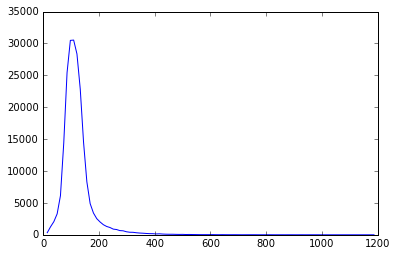

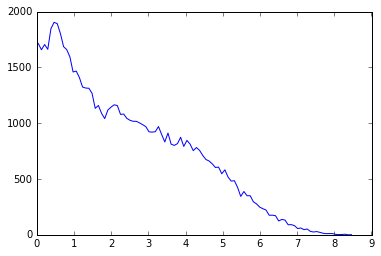

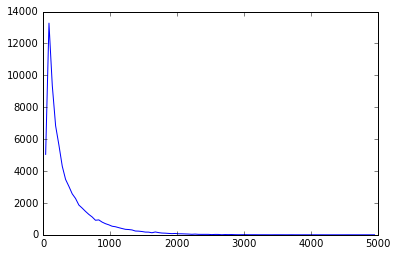

C:\Users\Ana\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: overflow encountered in long_scalars


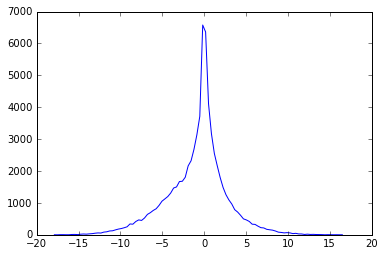

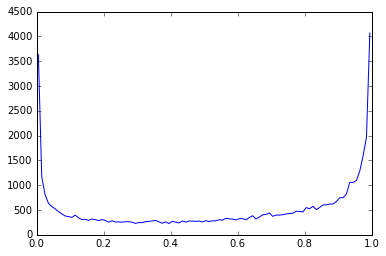

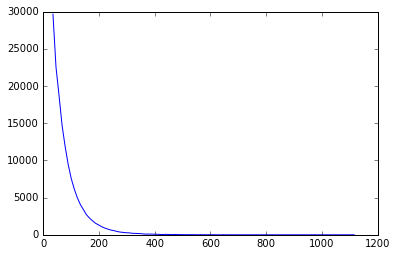

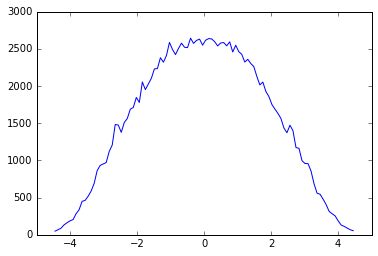

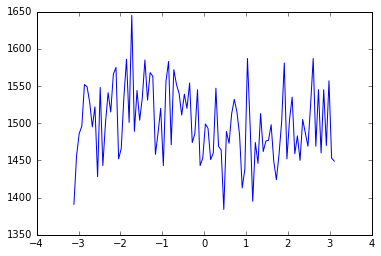

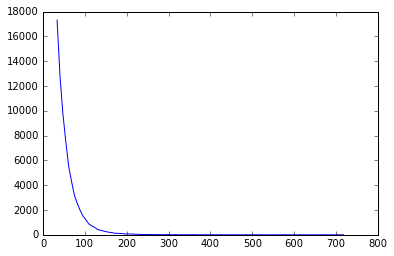

In [ ]:
print (tX)
lista = []
for i in range(tX.shape[1]):
    if -999 in tX[:,i]: lista.append(i)
for i in lista:
    tX_tmp = list(filter((-999.0).__ne__, tX[:,i]))
    x, prob = calculate_prob(tX_tmp,100)
    plt.plot(x,prob)
    plt.show()
    means = make_distribution(x,prob,list(tX[:,i]).count(-999.0))
    np.random.shuffle(means)
    np.place(tX[:,i], tX[:,i] == -999.0, means)
print(tX.shape[1])

In [ ]:
tX = feature_process(tX)
tX, mean_x, std_x = standardize(tX)
print(tX.shape[1])

## Do your thing crazy machine learning thing here :) ...

In [6]:
from machine_learning_tools.costs import *

from machine_learning_tools.gradient_descent import *
from machine_learning_tools.stochastic_gradient_descent import *

from machine_learning_tools.least_squares import *
from machine_learning_tools.ridge_regression import *
from data_tools.cross_validation import *

In [7]:
from util.plots import cross_validation_visualization

def cross_validation_demo():
    seed = 6
    degree = 30
    k_fold = 4
    #lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    rmse_tr_lambda=0
    rmse_te_lambda=0
    for k in range(k_fold):
        rmse_tr_k, rmse_te_k = cross_validation(y,tX,k_indices,k,degree)
        rmse_tr_lambda+=rmse_tr_k
        rmse_te_lambda+=rmse_te_k
    print(rmse_tr_lambda/k_fold)
    print(rmse_te_lambda/k_fold)
    #rmse_tr.append(rmse_tr_lambda/k_fold) 
    #rmse_te.append(rmse_te_lambda/k_fold)    
    
    #cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

65.5766539029
3.89517001093e+16


In [39]:
fi_r = build_poly(tX, 30) #degree should be much bigger than 30, but it takes long to execute
weight_r = ridge_regression(y, fi_r, 1000)
print(weight_r) #because values of fi function are very big, lambda factor doesn't do much and weight doesn't become sparse
                #as it should be: HINT: change function fi in a right way, or put really big lambda (10^100)
rmse_r = np.sqrt(2*compute_mse_ridge(y,fi_r,weight_r, 1000))
print(rmse_r)

[  1.72753659e+00  -2.63402936e-01   1.92650699e-02  -2.36599210e-03
  -1.23968315e-03  -1.55771923e-03   9.40127691e-04  -1.98436369e-04
   2.10329203e-05  -1.15869248e-06   2.49409207e-08   4.76019616e-10
  -2.96307690e-11   9.99682695e-15   1.64660663e-14  -1.59629868e-16
   2.20626118e-18  -1.06166203e-19  -3.26328000e-21   5.02412533e-23
   5.03864684e-24  -1.13853984e-25   4.83062737e-29  -2.99861696e-29
   1.41602354e-30   1.39854942e-32  -4.19545708e-34  -1.28527198e-35
  -2.71627887e-37   1.97579448e-38  -2.02048906e-40]
78.1905328434


In [40]:
#TODO : 
# 1) look at data to see if there are special values to be changed
#(for example there are a lot of -999 values in the train.csv i dont know what we should do with them)
# if nb of -999 is greater than x% drop the feature. otherwise learn about the distribution of the values to randomly
# assign values according to this distribution
# 2) standardize features (subtract mean like in lab1)
# 3) test first version to see if it works : use 'logistic_regression' on data and submit a first time on kaggle
# when it works, improve with following : 
# 4) do cross-validation on data
# 5) feature-processing : maybe some features are not necessary, or add features that are a power of an existing feature


## Generate predictions and save ouput in csv format for submission:

In [41]:
DATA_TEST_PATH = "data/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test, mean, std = standardize(tX_test)
tX_test = np.c_[np.ones((tX_test.shape[0], 1)), tX_test]

In [43]:
OUTPUT_PATH = 'predictions.csv'
fi = build_poly(tX, 30)
weight = least_squares(y,fi)
y_pred = predict_labels(weight, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)